In [24]:
import os
#from IPython.display import HTML

#Tables and matrices
import numpy as np
import pandas as pd

#Stats
import scipy.stats as st
from scipy.optimize import fmin
from scipy import integrate
from scipy.stats.mstats import mquantiles
import statistics 


#Probabilistic programs
#!pip install pymc==5.0.2
#!pip install pytensor
import pymc as pm
import pytensor.tensor as pt
import pytensor 
#import aesara.tensor as at
print('Running on PyMC v{}'.format(pm.__version__))
print('Running on Pytensor v{}'.format(pytensor.__version__))

#Graphs
import seaborn as sns
import plotly.graph_objects as go
import altair as alt
#from altair_saver import save #ademas instalar en terminal: brew cask install chromedriver
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from matplotlib.lines import Line2D
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
#from graphviz import Source, Digraph
#import dot2tex as d2t
#from latex import build_pdf
from mpl_toolkits.mplot3d import axes3d
import arviz as az

#User-defined functions (in the same folder as the notebook)
import my_fun as mf


Running on PyMC v5.1.0
Running on Pytensor v2.10.1


# Reinforced Learning

Santiago Alonso-Díaz

<center><img src="img/11_CB/SuttonBarto.png" width = "600" height = '600'></center>

In [5]:
%%HTML
<video width="620" height="540" controls>
  <source src="img/11_CB/ReinforcedLearningVideogames.mov">
</video>

<center><img src="img/11_CB/Mnih2015.png" width = "600" height = '600'></center>
Mnih et al, 2015

<center><img src="img/11_CB/Triqui1.png" width = "400" height = '400'></center>


In this state S, there are only two available actions (G, H)
<center><img src="img/11_CB/Triqui2.png" width = "400" height = '400'></center>


Which of this states is more valuable under a random policy? Green/X plays
<center><img src="img/11_CB/Triqui3.png" width = "600" height = '600'></center>


One way to learn the value of a state (V(s)) after doing action (a) at time t+1 is reinforced learning? For instance,
<br><br>
$$V(s)_{t+1} = V(s)_{t} + \alpha (V(s)_{t} - R(s)_{t+1}) $$
<br>
$\alpha$: Learning rate
$R$: Reward 
$t$: Time


More generally, reinforced learning rules usually take this abstract form:

$$ New \; Estimate \leftarrow Old \; Estimate  + StepSize [Target - Old \; Estimate] $$

# Case: Multiarmed Bandit

<center><img src="img/11_CB/MAB1.png" width = "600" height = '600'></center>
Daw, et al, 2006

$q(a)$ is an idealized quantity i.e. the actual expected value of doing action $a$:
$$q(a) \dot{=} \mathbb{E}[R_t | A_t = a] $$
<br>
One should pick the arm with the highest $q(a)$:
$$Argmax_a q(a)$$

Problem: we do not know $q(a)$. Thus, we symbolize our current estimate at time $t$ as:
$$ Q_t (a)$$

One possibility for $Q_t(a)$ is the mean of the rewards $R$ up to time $t-1$ when choosing $a$:

$$ Q_t(a) = \frac{\sum_{i=1}^{t-1}R_i*\mathbb{1}_{A_i=a}}{\sum_{i=1}^{t-1}\mathbb{1}_{A_i=a}}$$

We don't need perfect memory, we can obtain the average through reinforced learning:

<center><img src="img/11_CB/MAB5.png" width = "600" height = '600'></center>


<H2 style="text-align: center;">Dilemma</H2>
<p style="text-align: center;">Exploit ($Argmax_a Q_t(a)$)</p>
<p style="text-align: center;">vs</p>
<p style="text-align: center;">Explore (other non $Argmax$)</p>

Algorithm examples:
* Greedy ($Argmax_a Q_t(a)$)
* $\epsilon$-greedy ($Argmax_a Q_t(a)$ with probability $1-\epsilon$, uniform with probability $\epsilon$)
 

Which one to choose with a greedy policy?
<center><img src="img/11_CB/MAB2.png" width = "500" height = '500'></center>


What is the probability of choosing 143 with $\epsilon=0.5$?
<center><img src="img/11_CB/MAB2.png" width = "500" height = '500'></center>


The greedy algorithm only exploits, while $\epsilon$-greedy allows for exploration

Which policy is better? It depends
<center><img src="img/11_CB/MAB3.png" width = "500" height = '500'></center>
Sutton & Barto, 2020



Some simulations:

<center><img src="img/11_CB/MAB4.png" width = "500" height = '500'></center>

Sutton & Barto, 2020

Which policy is better? It depends ... e.g. on the variance of rewards

A popular policy is to use a softmax function that maps a vector of real values to the interval [0,1]:

$$Pr\{A_t=a\} = \pi_t(a) \dot{=}  \frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}}$$

$H_t(a)$: Strength of preference towards option $a$ (e.g. a linear transformation of $Q_t(a)$)


# Bayesian Estimation

In [8]:
#This section is mostly (99.9%) from pymc website: https://www.pymc.io/projects/examples/en/latest/case_studies/reinforcement_learning.html
#Also in archive: https://archive.ph/Srci7
#It simulates a 2-arm stationary problem

In [22]:
def generate_data(rng, alpha, beta, n=100, p_r=None):
    #Data for a 2-arm stationary problem from an idealized RL agent
    #alpha: learning rate
    #beta: softmax temperature parameter
    if p_r is None:
        p_r = [0.4, 0.6] #true reward probability i.e. stationary problem
    actions = np.zeros(n, dtype="int")
    rewards = np.zeros(n, dtype="int")
    Qs = np.zeros((n, 2))

    # Initialize Q table
    Q = np.array([0.5, 0.5]) #Rewards are 0 or 1 e.g. if 0.5, starting value on the middle 
    for i in range(n):
        # Apply the Softmax transformation
        exp_Q = np.exp(beta * Q)
        prob_a = exp_Q / np.sum(exp_Q)

        # Simulate choice and reward
        a = rng.choice([0, 1], p=prob_a)
        r = rng.random() < p_r[a] #0 no reward, 1 reward

        # Update Q table
        Q[a] = Q[a] + alpha * (r - Q[a])

        # Store values
        actions[i] = a
        rewards[i] = r
        Qs[i] = Q.copy()

    return actions, rewards, Qs

In [23]:
rng = np.random.default_rng()
true_alpha = 0.5
true_beta = 5
n = 150
actions, rewards, Qs = generate_data(rng, true_alpha, true_beta, n) #Idealized RL agent

In [13]:
actions

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1])

In [14]:
rewards

array([0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0])

In [15]:
Qs

array([[0.5       , 0.25      ],
       [0.75      , 0.25      ],
       [0.375     , 0.25      ],
       [0.6875    , 0.25      ],
       [0.34375   , 0.25      ],
       [0.34375   , 0.125     ],
       [0.171875  , 0.125     ],
       [0.5859375 , 0.125     ],
       [0.79296875, 0.125     ],
       [0.39648438, 0.125     ],
       [0.69824219, 0.125     ],
       [0.34912109, 0.125     ],
       [0.17456055, 0.125     ],
       [0.08728027, 0.125     ],
       [0.08728027, 0.5625    ],
       [0.54364014, 0.5625    ],
       [0.27182007, 0.5625    ],
       [0.27182007, 0.28125   ],
       [0.13591003, 0.28125   ],
       [0.13591003, 0.640625  ],
       [0.13591003, 0.8203125 ],
       [0.13591003, 0.91015625],
       [0.13591003, 0.45507812],
       [0.13591003, 0.72753906],
       [0.13591003, 0.86376953],
       [0.13591003, 0.43188477],
       [0.13591003, 0.71594238],
       [0.13591003, 0.35797119],
       [0.13591003, 0.1789856 ],
       [0.56795502, 0.1789856 ],
       [0.

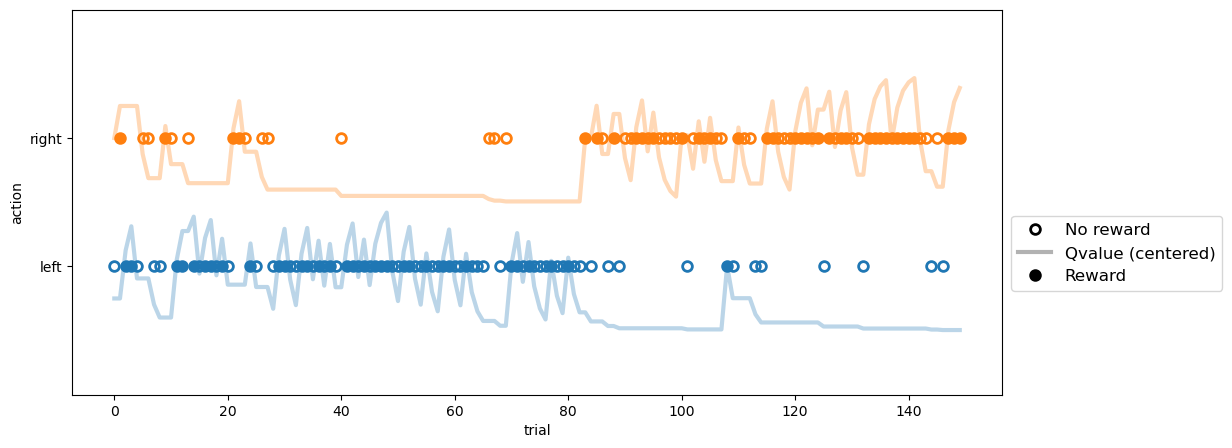

In [28]:
_, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(actions))

ax.plot(x, Qs[:, 0] - 0.5 + 0, c="C0", lw=3, alpha=0.3) #the minus 0.5 + 0 is a plotting gimmick
ax.plot(x, Qs[:, 1] - 0.5 + 1, c="C1", lw=3, alpha=0.3) #the minus 0.5 + 1 is a plotting gimmick

s = 7
lw = 2

cond = (actions == 0) & (rewards == 0)
ax.plot(x[cond], actions[cond], "o", ms=s, mfc="None", mec="C0", mew=lw)

cond = (actions == 0) & (rewards == 1)
ax.plot(x[cond], actions[cond], "o", ms=s, mfc="C0", mec="C0", mew=lw)

cond = (actions == 1) & (rewards == 0)
ax.plot(x[cond], actions[cond], "o", ms=s, mfc="None", mec="C1", mew=lw)

cond = (actions == 1) & (rewards == 1)
ax.plot(x[cond], actions[cond], "o", ms=s, mfc="C1", mec="C1", mew=lw)

ax.set_yticks([0, 1], ["left", "right"])
ax.set_ylim(-1, 2)
ax.set_ylabel("action")
ax.set_xlabel("trial")

reward_artist = Line2D([], [], c="k", ls="none", marker="o", ms=s, mew=lw, label="Reward")
no_reward_artist = Line2D(
    [], [], ls="none", marker="o", mfc="w", mec="k", ms=s, mew=lw, label="No reward"
)
Qvalue_artist = Line2D([], [], c="k", ls="-", lw=3, alpha=0.3, label="Qvalue (centered)")

ax.legend(handles=[no_reward_artist, Qvalue_artist, reward_artist], fontsize=12, loc=(1.01, 0.27));

Now let's model this data that we generated from an idealized RL agent

In [30]:
def update_Q(action, reward, Qs, alpha):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by pytensor.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the pytensor.scan fn argument:
        fn=lamba action, reward, Qs, alpha: pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """

    Qs = pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action])) #set_subtensor(x,y) is replace x with y, 
    return Qs

def pytensor_llik_td(alpha, beta, actions, rewards):
    rewards = pt.as_tensor_variable(rewards, dtype="int32")
    actions = pt.as_tensor_variable(actions, dtype="int32")

    # Compute the Qs values
    Qs = 0.5 * pt.ones((2,), dtype="float64")
    Qs, updates = pytensor.scan(
        fn=update_Q, sequences=[actions, rewards], outputs_info=[Qs], non_sequences=[alpha]
    ) #scan is used here as a for loop optimized for tensors over actions and rewards, and other parameters can go in non_sequences

    # Apply the sotfmax transformation and map those probabilities to log. space (for computing purposes i.e. multiplication turn to sums in log. space)
    Qs = Qs[:-1] * beta #in the next step we exp(Qs)/sum(exp(Qs))
    logp_actions = Qs - pt.logsumexp(Qs, axis=1, keepdims=True) #log property i.e. log(a/b) = log(a)-log(b) 

    # Calculate the log likelihood of the observed actions i.e. Qs is bidimensional (a column for each arm) and we only use the logp of the observed action
    logp_actions = logp_actions[pt.arange(actions.shape[0] - 1), actions[1:]] 
    return pt.sum(logp_actions)  # PyMC expects the standard log-likelihood

In [31]:
with pm.Model() as m:
    #Priors
    alpha = pm.Beta(name="alpha", alpha=1, beta=1)
    beta = pm.HalfNormal(name="beta", sigma=10)
    
    #Likelihood
    like = pm.Potential(name="likelihood", var=pytensor_llik_td(alpha, beta, actions, rewards))

    tr = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int64 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


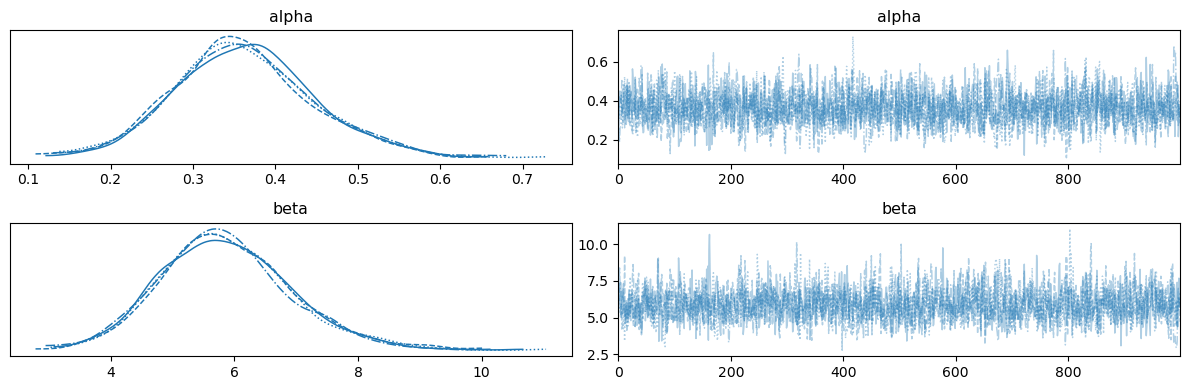

In [34]:
az.plot_trace(tr);
plt.tight_layout()

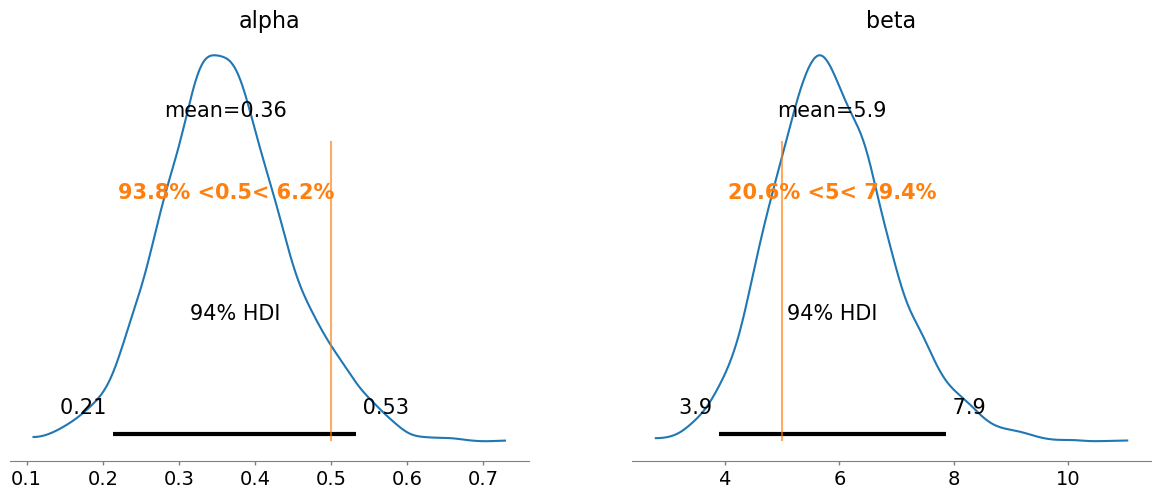

In [35]:
#The true values are within the posterior
az.plot_posterior(data=tr, ref_val=[true_alpha, true_beta]);

# We can also use a Bernoulli probability

With Bernoulli likelihood one can then do prior and posterior predictive sampling as well as model comparison.

In [36]:
def right_action_probs(alpha, beta, actions, rewards):
    rewards = pt.as_tensor_variable(rewards, dtype="int32")
    actions = pt.as_tensor_variable(actions, dtype="int32")

    # Compute the Qs values
    Qs = 0.5 * pt.ones((2,), dtype="float64")
    Qs, updates = pytensor.scan(
        fn=update_Q, sequences=[actions, rewards], outputs_info=[Qs], non_sequences=[alpha]
    ) #scan is used here as a for loop optimized for tensors over actions and rewards, and other parameters can go in non_sequences


    # Apply the sotfmax transformation and map those probabilities to log. space (for computing purposes i.e. multiplication turn to sums in log. space)
    Qs = Qs[:-1] * beta #in the next step we exp(Qs)/sum(exp(Qs))
    logp_actions = Qs - pt.logsumexp(Qs, axis=1, keepdims=True) #log property i.e. log(a/b) = log(a)-log(b) 

    # Return the probabilities for the right action, in the original scale
    return pt.exp(logp_actions[:, 1])

In [38]:
with pm.Model() as m_alt:
    #Priors
    alpha = pm.Beta(name="alpha", alpha=1, beta=1)
    beta = pm.HalfNormal(name="beta", sigma=10)

    #Likelihood`
    action_probs = right_action_probs(alpha, beta, actions, rewards)
    like = pm.Bernoulli(name="like", p=action_probs, observed=actions[1:])

    tr_alt = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int64 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


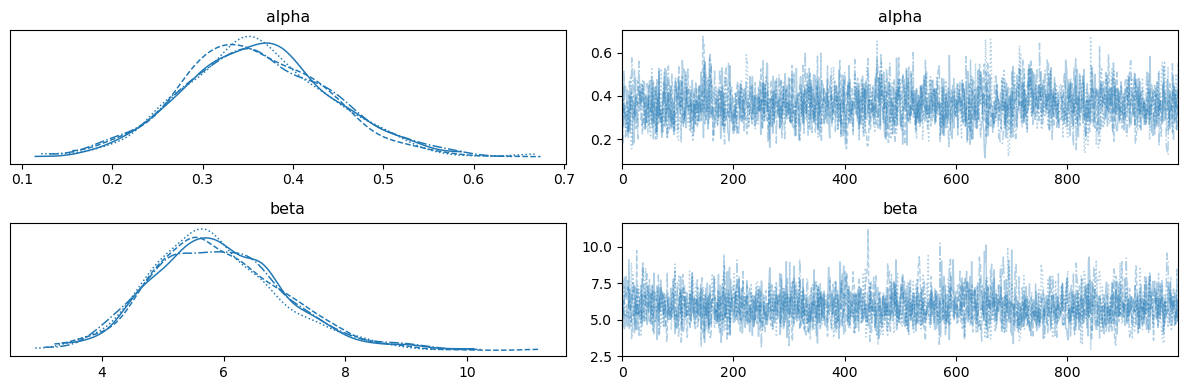

In [40]:
az.plot_trace(data=tr_alt);
plt.tight_layout()

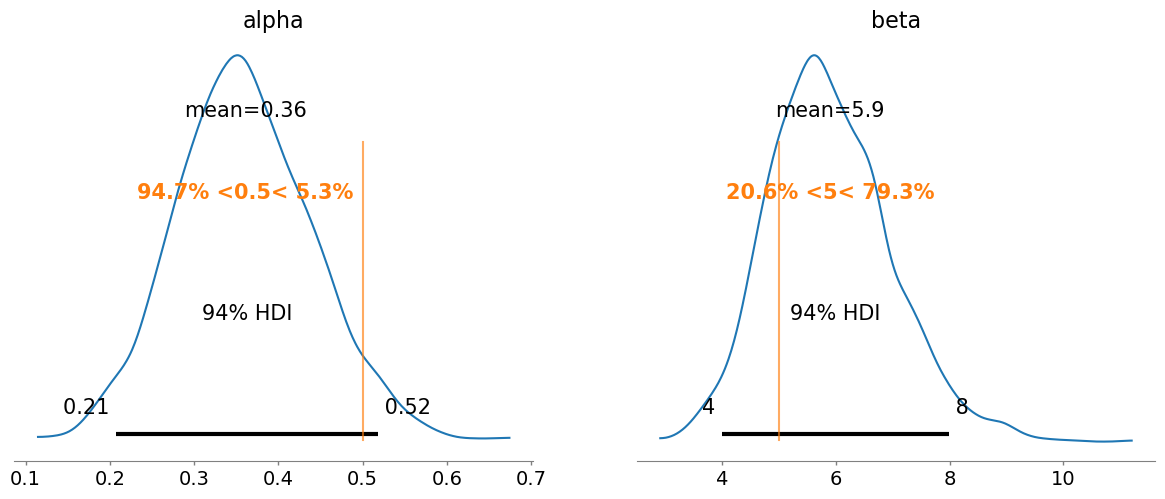

In [41]:
az.plot_posterior(data=tr_alt, ref_val=[true_alpha, true_beta]);

# Human Data
Now let's use your data


In [86]:
#Stimulus in: https://pavlovia.org/santiagoalonsodiaz/mab_philiastides 
#based on a public pavlovia experiment, created by a Philiastides lab phd student
#Task description: two arms on each trial but there were four colors
#Even though four colors, there were only two types:
#1,2 equal value and highest; 3,4 equal value and lowest

data_MAB = pd.read_csv('data/11_CB/MAB_online_task.csv')
cols = ['left_rew_dbl', 'right_rew_dbl', 'stim1', 'stim2', 'correct',
        'key_resp_3.keys', 'key_resp_3.rt', 'trials_3.thisTrialN'] #cols with relevant data
#rew: reward
#dbl: double type
#stim1: left arm (1 to 4, one for each color) 1,2 equal value and highest; 3,4 equal value and lowest
#stim2: right arm
#correct: actual correct response i.e. this answer would be the correct one to chose (0 left, 1 right, NaN both arms have equal value)
#.keys: observed subject response str ('left', 'right')
#.rt: subject response time
#..thisTrialN: trial number

data_MAB = data_MAB.loc[:, cols]
data_MAB.replace('left', 0, inplace = True)
data_MAB.replace('right', 1, inplace = True)
data_MAB['accuracy'] = data_MAB['correct']==data_MAB['key_resp_3.keys']
data_MAB['accuracy'] = np.array(data_MAB['accuracy'], dtype=int)
idx = (np.isnan(data_MAB['correct']))
data_MAB.loc[idx,'accuracy'] = np.round(np.random.rand(idx.sum()))
idx = (np.isnan(data_MAB['key_resp_3.keys']))
data_MAB.loc[idx,'accuracy'] = np.nan


temp1 = data_MAB.groupby(['stim1']).mean(numeric_only=True).loc[:,'left_rew_dbl']
temp2 = data_MAB.groupby(['stim2']).mean(numeric_only=True).loc[:,'right_rew_dbl']
reward_mean_by_color = pd.concat([temp1, temp2], axis = 1).mean(axis=1) #1,2 equal value and highest; 3,4 equal value and lowest
reward_mean_by_color

1    60.450000
2    59.677632
3    39.190537
4    40.006579
dtype: float64

In [88]:
[data_MAB.dtypes]

[left_rew_dbl             int64
 right_rew_dbl            int64
 stim1                    int64
 stim2                    int64
 correct                float64
 key_resp_3.keys        float64
 key_resp_3.rt          float64
 trials_3.thisTrialN      int64
 accuracy               float64
 dtype: object]

In [ ]:
def right_action_probs(alpha, beta, actions, rewards):
    rewards = pt.as_tensor_variable(rewards, dtype="int32")
    actions = pt.as_tensor_variable(actions, dtype="int32")

    # Compute the Qs values
    Qs = 0.5 * pt.ones((2,), dtype="float64")
    Qs, updates = pytensor.scan(
        fn=update_Q, sequences=[actions, rewards], outputs_info=[Qs], non_sequences=[alpha]
    ) #scan is used here as a for loop optimized for tensors over actions and rewards, and other parameters can go in non_sequences


    # Apply the sotfmax transformation and map those probabilities to log. space (for computing purposes i.e. multiplication turn to sums in log. space)
    Qs = Qs[:-1] * beta #in the next step we exp(Qs)/sum(exp(Qs))
    logp_actions = Qs - pt.logsumexp(Qs, axis=1, keepdims=True) #log property i.e. log(a/b) = log(a)-log(b) 

    # Return the probabilities for the right action, in the original scale
    return pt.exp(logp_actions[:, 1])

### Exercise
How to include the fact the there were four colors even though it was a two arm problem?